<a href="https://colab.research.google.com/github/karthikpuranik11/Hope-Speech-Detection-/blob/main/Roberta_base_uncased_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==3.3.1

     |████████████████████████████████| 1.1MB 24.8MB/s 
     |████████████████████████████████| 3.0MB 52.5MB/s 
     |████████████████████████████████| 1.1MB 41.7MB/s 
     |████████████████████████████████| 890kB 55.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=f6d65dc801b02a4a1ba22c2fdc77bfb0d46872bd63276fac4c73e335ce9abb7c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
train=pd.read_csv('/content/english_hope_train.tsv', header=None, names=['tweets','label'], sep="\t")
train['labels']=LabelEncoder().fit_transform(train['label'])
train=train.drop(columns='label')
train

,tweets,labels
0,these tiktoks radiate gay chaotic energy and i...,1
1,@Champions Again He got killed for using false...,1
2,It's not that all lives don't matter,1
3,Is it really that difficult to understand? Bla...,1
4,Whenever we say black isn't that racists? Why...,1
...,...,...
22757,It's a load of bollocks every life matters sim...,1
22758,no say it because all lives matter! deku would...,1
22759,God says her life matters,1
22760,This video is just shit. A bunch of whiny ass ...,1


In [ ]:
val=pd.read_csv('/content/english_hope_dev.tsv', header=None, names=['tweets','label'], sep="\t")
val['labels']=LabelEncoder().fit_transform(val['label'])
val=val.drop(columns='label')
val

,tweets,labels
0,Thats it.... like....I dont like that statue,1
1,@Generation X Counting money that she been giv...,1
2,@Paola Hernandez i never said to be intolerant...,1
3,@Firstlast300 Wow An opinion is that I don't l...,1
4,WOW!!!!!!!That was so so inspiring and incredi...,0
...,...,...
2838,Such fake sentiment. .,1
2839,@A G black lives arent undervalued compared to...,1
2840,People who pulled it down can and will be arre...,1
2841,@Aaron Castellanos It will be a two hour movie...,1


In [ ]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader

class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [ ]:
print('Training set size:',train.shape)
print('validation set size:',val.shape)

Training set size: (22762, 2)
validation set size: (2843, 2)


In [ ]:
import numpy as np

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train.labels.values),
                                                  train.labels.values)
class_weights

array([  3.86714237,   0.36516187, 344.87878788])

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = RFDataset(
      text = df.tweets.to_numpy(),
      label = df.labels.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = True,
                    num_workers=4)

In [ ]:
from transformers import XLNetTokenizer,XLNetModel,AdamW,get_linear_schedule_with_warmup,AutoModel,AutoTokenizer
device = 'cuda'
PRE_TRAINED_MODEL_NAME = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [ ]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE)

In [ ]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('roberta-base')
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [ ]:
model = RFClassifier(3)
model = model.to(device)

In [ ]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:

def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from collections import defaultdict
import torch
 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'bert-base-uncased.bin')
    best_accuracy = val_acc

Epoch: 01 | Epoch Time: 8m 41s
Train Loss 0.2842886497141019 accuracy 0.9134083120991126
Val Loss 0.30153683305121537 accuracy 0.911712979247274

Epoch: 02 | Epoch Time: 8m 46s
Train Loss 0.22960252304080078 accuracy 0.9297513399525525
Val Loss 0.21661601839273165 accuracy 0.9212099894477664

Epoch: 03 | Epoch Time: 8m 45s
Train Loss 0.20962698317363104 accuracy 0.9360776733151744
Val Loss 0.2426119138476219 accuracy 0.9236721772775237

Epoch: 04 | Epoch Time: 8m 46s
Train Loss 0.18438100244122652 accuracy 0.9424040066777963
Val Loss 0.20832027000992487 accuracy 0.926134365107281

Epoch: 05 | Epoch Time: 8m 45s
Train Loss 0.1719633234884548 accuracy 0.9462261664177137
Val Loss 0.21681288861031278 accuracy 0.9208582483292297

Epoch: 06 | Epoch Time: 8m 45s
Train Loss 0.16045227932633854 accuracy 0.9507073192162376
Val Loss 0.21051751363896923 accuracy 0.9190995427365459

Epoch: 07 | Epoch Time: 8m 45s
Train Loss 0.14285163778492532 accuracy 0.9560671294262367
Val Loss 0.2160138818487692

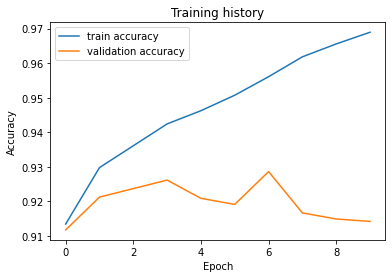

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1]);

In [ ]:
val_acc, _ = eval_model(
  model,
  val_data_loader,
  loss_fn,
  device,
  len(val) #Change it to test when you have the test results
)
val_acc.item()

0.9141751670770313

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  val_data_loader
)

In [ ]:
class_name = ['Hope_speech','Non_hope_speech','not-English']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0))

                 precision    recall  f1-score   support

    Hope_speech       0.55      0.60      0.58       272
Non_hope_speech       0.96      0.95      0.95      2569
    not-English       0.00      0.00      0.00         2

       accuracy                           0.91      2843
      macro avg       0.50      0.52      0.51      2843
   weighted avg       0.92      0.91      0.92      2843



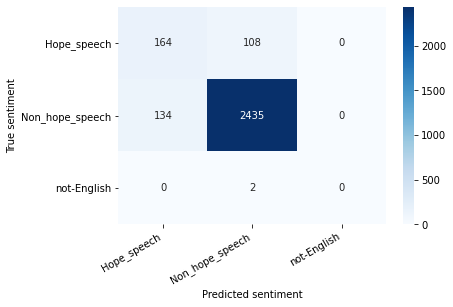

In [ ]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [ ]:
a={'id':[i for i in range(2843)]}
a=pd.DataFrame(a)



df=pd.DataFrame({'id': a.id, 'labels': y_pred})
df.labels = df.labels.apply({0:'Hope_speech', 1: 'non_hope_speech',2:'not-English'}.get)
df





,id,labels
0,0,Hope_speech
1,1,non_hope_speech
2,2,Hope_speech
3,3,Hope_speech
4,4,non_hope_speech
...,...,...
2838,2838,non_hope_speech
2839,2839,non_hope_speech
2840,2840,non_hope_speech
2841,2841,non_hope_speech


In [ ]:
df.to_csv('Roberta_base_english_submission.csv',index=False)

In [ ]:
from google.colab import files
files.download("Roberta_base_english_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>